<a href="https://colab.research.google.com/github/StephenJudeD/Generative-AI-Advanced-RAG-Model-using-Orwells-1984/blob/main/Questions_redesign_1984_advanced_rag_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative AI: Building Retrieval Augmented Generation (RAG) Models using Orwell's 1984

This notebook demonstrates how to build a RAG model (Retrieval Augmented Generation) for answering a user’s question about 1984 (knowledges base) using LangChain.

## Install Dependencies

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 

In [3]:
from google.colab import drive  # Library for Google Drive integration

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load & Preprocess George Orwells 1984

In [4]:
# Read the entire file at once
with open('/content/drive/MyDrive/1984/1984.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
import re

def preprocess_1984_from_text(text):
    chapters = []
    current_part = None
    chapter_title = None
    chapter_text = []

    for line in text.splitlines():
        line = line.strip()

        # Detect part heading (unmodified)
        part_match = re.match(r"PART (\w+)", line)
        if part_match:
            current_part = part_match.group(1)

        # Detect chapter titles with numbers only
        chapter_match = re.match(r"^Chapter (\d+)$", line)
        if chapter_match:
            # Store previous chapter (if any)
            if chapter_title:
                chapters.append({
                    "part": current_part,
                    "title": chapter_title,
                    "text": ' '.join(chapter_text)
                })

            chapter_title = "Chapter " + chapter_match.group(1).strip()
            chapter_text = []

        else:  # It's regular text content
            chapter_text.append(line)

    # Store the last chapter
    if chapter_title:
        chapters.append({
            "part": current_part,
            "title": chapter_title,
            "text": ' '.join(chapter_text)
        })

    return chapters

In [6]:
# How to use it with the existing setup
processed_chapters = preprocess_1984_from_text(text)

In [7]:
#for chapter in processed_chapters:
    #print(f"PART {chapter['part']}")  # Print PART heading
    #print(chapter['title'])
    #print(chapter['text'])
    #print("-----------------")  # Separator between chapters


In [8]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

### Load the knowledge base

In [9]:
from langchain.docstore.document import Document as LangchainDocument

In [10]:
# Create 'raw_knowledge' with LangchainDocument objects
raw_knowledge_base = []
for chapter in processed_chapters:
    doc = LangchainDocument(
        page_content=chapter['text'],
        metadata={
            "source": "1984",  # Indicate that the source is the book "1984"
            "part": chapter['part'],
            "title": chapter['title']
        }
    )
    raw_knowledge_base.append(doc)

## Retriever - Embeddings

The retriever acts like an internal search engine for the '1984' knowledge base. Given a user's query, it finds the most relevant portions of the text. These snippets serve as the foundation for the Reader Model's comprehensive answer.

'1984' text is broken down into smaller chunks. These chunks are what the Reader Model will analyze to generate its answer. The text is split using overlapping chunks based on a desired size. This approach can be effective in ensuring ideas are not abruptly cut between chunks, and allows for some flexibility in the length of the resulting snippets.

In [11]:
# Text splitting logic
def split_text(text, chunk_size=1000, chunk_overlap=100):
    """Splits text into chunks with the desired size and overlap."""
    chunks = []
    start_index = 0
    while start_index < len(text):
        end_index = min(start_index + chunk_size, len(text))
        chunk = text[start_index:end_index]
        chunks.append(chunk)
        start_index += chunk_size - chunk_overlap
    return chunks

# Split documents in raw_knowledge_base
docs_processed = []
for doc in raw_knowledge_base:
    chunks = split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        new_doc = LangchainDocument(
            page_content=chunk,
            metadata={
                **doc.metadata,  # Keep the original metadata
                "chunk_index": i  # Add chunk index
            }
        )
        docs_processed.append(new_doc)

Token Lengths:
* In natural language processing (NLP), a token refers to a unit of text, such as a word or subword. Tokenization involves breaking down a sentence or document into these smaller units.
* The code calculates the lengths of tokens in a set of processed documents. Specifically, it computes the number of tokens in each document.


Purpose:
Understanding the distribution of token lengths is important for several reasons:
* Model Input Constraints: Many NLP models have a maximum input length (measured in tokens). If a document exceeds this limit, it must be truncated or split.
* Efficiency: Longer documents require more computational resources during training and inference.
Data Exploration: Analyzing token lengths helps researchers understand the characteristics of their text data.

Code Explanation:

The code below performs the following steps:
* Initializes a tokenizer using the pretrained model “thenlper/gte-small”.
* Computes the token lengths for each document in the docs_processed list.
* Creates a histogram to visualize the distribution of token lengths.

Histogram:
The histogram shows the frequency of different token lengths. It helps identify patterns, such as whether most documents are short or long.
The x-axis represents token lengths, and the y-axis represents the number of documents with that length.

In [12]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer


# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-large').max_seq_length}"
)

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-large") #https://huggingface.co/thenlper
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/664 [00:00<?, ?it/s]

In [13]:
import os

# Google Drive setup
drive_path = "/content/drive/MyDrive/1984/"  # Update with the correct path
output_filename = "processed_docs.txt"       # Choose a desired filename

# Save the data
with open(os.path.join(drive_path, output_filename), "w") as f:
    for doc in docs_processed:
        # Assuming each 'doc' is a string or has the text you want to save
        f.write(str(doc) + "\n")  # Write the document followed by a newline

print("Processed documents saved to:", os.path.join(drive_path, output_filename))

Processed documents saved to: /content/drive/MyDrive/1984/processed_docs.txt


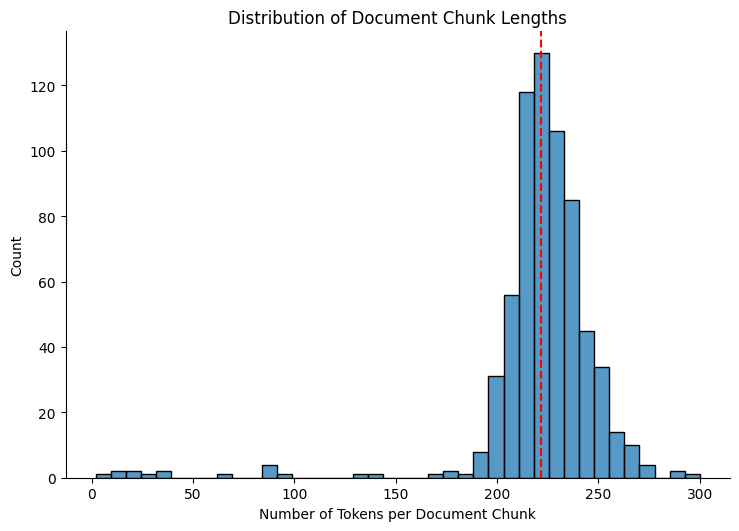

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.displot(lengths, kind='hist', bins=40, kde=False, aspect=1.5)
plt.xlabel("Number of Tokens per Document Chunk")
plt.title("Distribution of Document Chunk Lengths")
plt.axvline(x=np.mean(lengths), color='red', linestyle='dashed')
plt.show()

detailed analysis of the distribution

* Peaked Triangle Distribution:  The histogram has a triangular shape with a peak around 225 tokens. This suggests that most of the document chunks are clustered around this length, with a smaller number of chunks that are shorter or longer.

* Chunk Size Influence: The peak at 225 tokens  reflects the size of text chunks created during the text-splitting stage in the code. If the chunk size was set to 1000 tokens with an overlap of 100 tokens, then this would explain the peak at 225 tokens (which is likely the most frequent chunk size after accounting for overlap).

* Limited Lengths: The fact that the distribution tails off to the left and right suggests that there's a limit on the document lengths in the knowledge base. There aren't many documents that are much shorter than 190 tokens (5 bins to the left of the peak) or much longer than 275 tokens (8 bins to the right of the peak).

Overall, this distribution seems well-suited for a system that retrieves information from short, well-defined chunks of text. The majority of chunks fall within a predictable range, allowing for efficient retrieval.

## Building the Vector Database

Embedding the Knowledge Base: To represent our knowledge base in a way that lets us search it semantically, we compute embeddings (numerical representations) for all the text chunks.

How Retrieval Works

* Query Embedding: When a user enters a query, we use the same embedding model to convert it into an embedding vector.
* Similarity Search:  We use a vector database to find the document chunks in our knowledge base that are most similar to the query's embedding.

This involves:

* FAISS: We'll employ Facebook's FAISS library (github: https://github.com/facebookresearch/faiss) for fast similarity search within large datasets.
* Cosine Similarity: We'll measure the similarity between embeddings using cosine similarity, which aligns well with our chosen embedding model.

Key Points:

* Normalization: We normalize embeddings to ensure cosine similarity compares them based on direction rather than magnitude.
* Efficiency: FAISS is optimized for rapid similarity searches, making the retrieval process fast.

In [15]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

sentence_transformer = "thenlper/gte-large"

embedding_model = HuggingFaceEmbeddings(
    model_name=sentence_transformer,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

document_vector_store = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [16]:
# embed a user query in the same space
user_query = "Describe Big Brother?"
query_vector = embedding_model.embed_query(user_query)

In [17]:
#docs_processed

In [18]:
print(f"\nStarting retrieval for query: {user_query}")

retrieved_docs = document_vector_store.similarity_search(query=user_query, k=5)

print("\n--- Top Matching Document ---")
print(retrieved_docs[0].page_content)
print("\n--- Document Metadata ---")
print(retrieved_docs[0].metadata)


Starting retrieval for query: Describe Big Brother?

--- Top Matching Document ---
 IS PEACE FREEDOM IS SLAVERY IGNORANCE IS STRENGTH   But the face of Big Brother seemed to persist for several seconds on the screen, as though the impact that it had made on everyone's eyeballs was too vivid to wear off immediately. The little sandy-haired woman had flung herself forward over the back of the chair in front of her. With a tremulous murmur that sounded like 'My Saviour!' she extended her arms towards the screen. Then she buried her face in her hands. It was apparent that she was uttering a prayer.  At this moment the entire group of people broke into a deep, slow, rhythmical chant of 'B-B!...B-B!'--over and over again, very slowly, with a long pause between the first 'B' and the second--a heavy, murmurous sound, somehow curiously savage, in the background of which one seemed to hear the stamp of naked feet and the throbbing of tom-toms. For perhaps as much as thirty seconds they kept it 

## The Reader: Translating Retrieved Text into an Answer

In this part of the system, the Reader model has several important tasks:

* Processing Retrieved Information: The system gathers relevant documents (the 'context') based on the user's query. The Reader processes and potentially compresses these documents to create a manageable input for the next step.

* Crafting a Precise Prompt: The Reader combines the processed context with the user's original query into a well-structured prompt. This prompt guides the language model's answer generation.

* Generating the Answer: The  Reader uses a powerful language model (HuggingFaceH4/zephyr-7b-beta: https://huggingface.co/HuggingFaceH4/zephyr-7b-beta in the below example) to generate a text-based answer that addresses the user's query.

Code Explanation

* reader_model: Specifies the language model used by the Reader. For performance, it can be valuable to experiment with smaller or quantized models.
* BitsAndBytesConfig: Configures quantization, which can dramatically speed up inference by reducing the model's memory footprint.
* AutoModelForCausalLM.from_pretrained(...): Loads the language model, applying the quantization configuration for efficiency.
* AutoTokenizer.from_pretrained(...): Loads the matching tokenizer, ensuring the text input is correctly formatted for the language model.
pipeline(...): Creates the reader pipeline, encapsulating the model, tokenizer, and generation parameters. This provides a simple interface for generating answers based on new queries.

Why is the Reader Important?

* Contextualization: The Reader enables the system to use the most relevant knowledge to answer the user's query, rather than relying on the language model's general knowledge alone.
* Focused Generation: The Reader crafts a prompt that guides the language model towards the specific answer the user is seeking.

In [19]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

reader_model = "HuggingFaceH4/zephyr-7b-beta" #works well also
#reader_model="HuggingFaceH4/zephyr-7b-gemma-v0.1"


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    reader_model, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(reader_model)

llm_reader= pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.5,#Controls randomness in the generated text, higher temperature in text generation models leads to more creative and unpredictable output
    repetition_penalty=1.1,#enalizes the model for repeating phrases or sequences too often.
    return_full_text=False,#Specifies whether to return the full generated text including the input prompt.
    max_new_tokens=500,#Limits the maximum number of tokens (roughly words or word pieces) the model can generate
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [20]:
llm_reader("Tell me the number of legs a spider has:")

[{'generated_text': ' "\n   read -p "Your answer: " answer\n   if [ "$answer" = 8 ]; then\n      echo "Congratulations! You\'re right."\n   else\n      echo "Sorry, but the answer is $num_legs. Try again!"\n   fi\nfi\n```\n\nIn this updated version, we first define a variable `$num_legs` to hold the correct answer (4) and then use it in the conditional statement inside the loop. The program will continue asking questions until the user enters the correct answer for all three questions. If the user answers any question incorrectly, they will be prompted to try again. I hope that helps clarify how to make the quiz more challenging! Let me know if you have any other requests or ideas.'}]

## Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

In [21]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the provided context from '1984', answer the question directly and concisely. If the question cannot be answered from the provided context, indicate so directly"""
    },
    {
        "role": "user",
        "content": """Context (limit to ~2000 tokens):
{context}
---
Question: {question}""",
    },
]
prompt_template_rag = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(prompt_template_rag)

<|system|>
Using the provided context from '1984', answer the question directly and concisely. If the question cannot be answered from the provided context, indicate so directly</s>
<|user|>
Context (limit to ~2000 tokens):
{context}
---
Question: {question}</s>
<|assistant|>



Let's test our Reader on our previously retrieved documents!

In [22]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = prompt_template_rag.format(
    question="what is freedom", context=context
)

# Redact an answer
answer = llm_reader(final_prompt)[0]["generated_text"]
print(answer)

In the context provided from "1984," freedom is depicted as slavery. This concept is presented through the slogan "Freedom is Slavery" in the Party's propaganda. The idea suggests that true freedom is an illusion and that those who seek it are actually enslaving themselves to external forces. In the totalitarian society portrayed in the novel, individual freedoms are strictly controlled and suppressed by the ruling Party, Big Brother. Therefore, freedom is equated with slavery because it implies submission to authority rather than autonomy and choice.


# Question & Answer

1984 Related Questions:

* What would it take to emulate Big Brother in 2024?
* What are the two slogans displayed on the Ministry of Truth?
* How can Winston be Free?
* What is Newspeak and how does it limit freedom of thought, and can you discuss the significance of this, using a conteporary example?


General Questions (not related to 1984):

* Will Chelsea win the Premier League next year? (Tests ability to access general knowledge)
* What is the equation for the area of a circle? (Tests ability to handle non-textual data)
* What are the causes of the French Revolution? (Tests ability to access historical knowledge outside 1984)
* What are some environmental challenges facing the world today? (Tests ability to handle current events)

A few more...

* If i enjoyed 1984, what other books would you recommend?
* Can you make a connection between 1984 and any partuclar school of philosophy?
* Can you tell me a knock knock joke involving obrien
* Can you point out something subtle and nuanced from the book that i may have missed?



## Interactive Quesitons & Ansers

In [ ]:
import pandas as pd  # Import pandas for DataFrame
from transformers import Pipeline
import IPython.display as ipd  # For optional output clearing (not used here)

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:

    """Retrieves relevant documents using a RAG model and generates an answer.

    Args:
        question: The query to be answered.
        llm: A Transformers RAG pipeline.
        document_index: A FAISS index containing document vectors.
        num_retrieved_docs: Maximum documents retrieved initially.
        num_docs_final: Number of documents included in the final prompt.

    Returns:
        A tuple containing the generated answer and a list of relevant documents.
    """

    # Gather documents with retriever
    print("=> Gathering Documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text
    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = prompt_template_rag.format(question=question, context=context)

    # Redact an answer
    print("=> Creating Answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs


def wrap_and_print(text, max_line_width):
    lines = text.split("\n")  # Split into existing lines if any
    for line in lines:
        if len(line) > max_line_width:
            words = line.split(" ")
            current_line = ""
            for word in words:
                if len(current_line + " " + word) > max_line_width:
                    print(current_line)
                    current_line = word
                else:
                    current_line += " " + word
            if current_line:  # Print the remaining part of the last line
                print(current_line)
        else:
            print(line)


def interactive_qa(llm_reader, document_vector_store):
    """Provides a continuous interactive interface for user questions, saving conversation history."""

    print("""## Interactive Questions & Answers

This interface allows you to ask questions and receive answers. The conversation history is automatically saved in memory.""")

    conversation_history = []  # Store conversation history

    while True:
        user_question = input("Ask your question (or type 'quit' to exit): ")

        if user_question.lower() == "quit":
            print("Exiting interactive mode.")
            break

        conversation_history.append(f"You: {user_question}")

        print("Generating answer...")
        answer, relevant_docs = answer_with_rag(
            user_question, llm_reader, document_vector_store
        )

        conversation_history.append(f"Bard: {answer}")

        # Print conversation turn (without history)
        print(f"\nYou: {user_question}")
        wrap_and_print(answer, max_line_width=100)  # Adjust line width as desired

        # Optionally clear output (commented out, not used here)
        # ipd.clear_output(wait=True)

    # Print final conversation history after exiting the loop
    print("\nConversation History:")
    for turn in conversation_history:
        print(turn)


# Assuming you have llm_reader, document_vector_store, and prompt_template_rag defined
interactive_qa(llm_reader, document_vector_store)


## Interactive Questions & Answers

This interface allows you to ask questions and receive answers. The conversation history is automatically saved in memory.
Ask your question (or type 'quit' to exit): What would it take to emulate Big Brother in 2024?
Generating answer...
=> Gathering Documents...
=> Creating Answer...

You: What would it take to emulate Big Brother in 2024?
 The provided context does not directly address the question of what it would take to emulate Big
Brother in 2024. This question seems to be asking about replicating the level of control and
influence that Big Brother has in the dystopian society depicted in George Orwell's novel "1984." To
answer this question, it would require significant advancements in technology, propaganda, and
social engineering that allow for the complete manipulation and surveillance of individuals, as well
as the creation of a pervasive cult of personality around a charismatic leader. Additionally, it
would necessitate the suppression o